# Imports

In [100]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import requests
import os
import cv2

# Webscrape

Webscrape list of all the counties (it also includes London, as they have a Gaelic team)

In [9]:
url = "http://www.prideinthejersey.com/jerseysindex.html"

countyList = []

try:
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')

    divs = soup.findAll('div')
    
    for div in divs:
        a_tag = div.find('a')
        if a_tag and 'href' in a_tag.attrs:
            countyList.append(a_tag['href'])
            
except requests.exceptions.HTTPError as err:
    print(f"HTTP error occurred: {err}")
except Exception as e:
    print(f"An error occurred: {e}")

countyList = [county.replace(".html", "") for county in countyList]
countyList.remove("NewYork") # This webpage is not available
countyList.remove("http://www.homestead.com/")
countyList.append("Tipperary") # This county was left out
countyList = [county.capitalize() for county in countyList]

print(countyList) # All 32 counties, plus also London

['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'Fermanagh', 'Galway', 'Kerry', 'Kilkenny', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Kildare', 'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'Tyrone', 'Waterford', 'Westmeath', 'Clare', 'Wexford', 'Wicklow', 'Tipperary']


In [17]:
options = Options()
options.add_argument("--headless")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

Download all the images for the kits for the counties and save them into their own folder

In [18]:
for county in countyList:
    # Ensure the 'Jerseys' directory exists
    base_dir = 'Jerseys'
    county_dir = os.path.join(base_dir, county)
    if not os.path.exists(county_dir):
        os.makedirs(county_dir)
    
    driver.get(f"http://www.prideinthejersey.com/{county}.html")

    try:
        element = driver.find_element(By.CLASS_NAME, "photoGalleryImageStageContainer")
        element.click()
        print(f"Downloading {county} Images")
    except Exception as e:
        print(f"Error clicking the element: {e}")

    time.sleep(1.25)
    
    for num in range(99):
        try:
            next_link = driver.find_element(By.ID, "nextLink")
            next_link.click()
            time.sleep(1)  # Corrected comment to match the delay
            
            # Get the image number and total count from the span element
            number_display_element = driver.find_element(By.ID, "numberDisplay")
            image_info = number_display_element.text.split()
            if len(image_info)>0:
                current_image_number = int(image_info[1])
                total_image_count = int(image_info[3])
            else:
                current_image_number=0
                total_image_count=1
            
            image_element = driver.find_element(By.ID, "lightboxImage")
            image_src = image_element.get_attribute('src')
            if image_src:
                response = requests.get(image_src)
                if response.status_code == 200:
                    image_path = os.path.join(county_dir, f'{county}_{num}.jpg')
                    with open(image_path, 'wb') as file:
                        file.write(response.content)
                else:
                    print("All images downloaded")
                    break
            # Check if all images have been downloaded
            if current_image_number == total_image_count:
                print("All images downloaded")
                break
    
        except Exception as e:
            print(f"Error clicking nextLink: {e}")
            break  # Exit the loop if there's an error (e.g., element not found)

driver.quit()

All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded


# Setup Data

The data will be split into training and test data

Remove the bottom of all the images as some of the images contain text\
Also remove a little from the top and sides to remove the box some of the images have

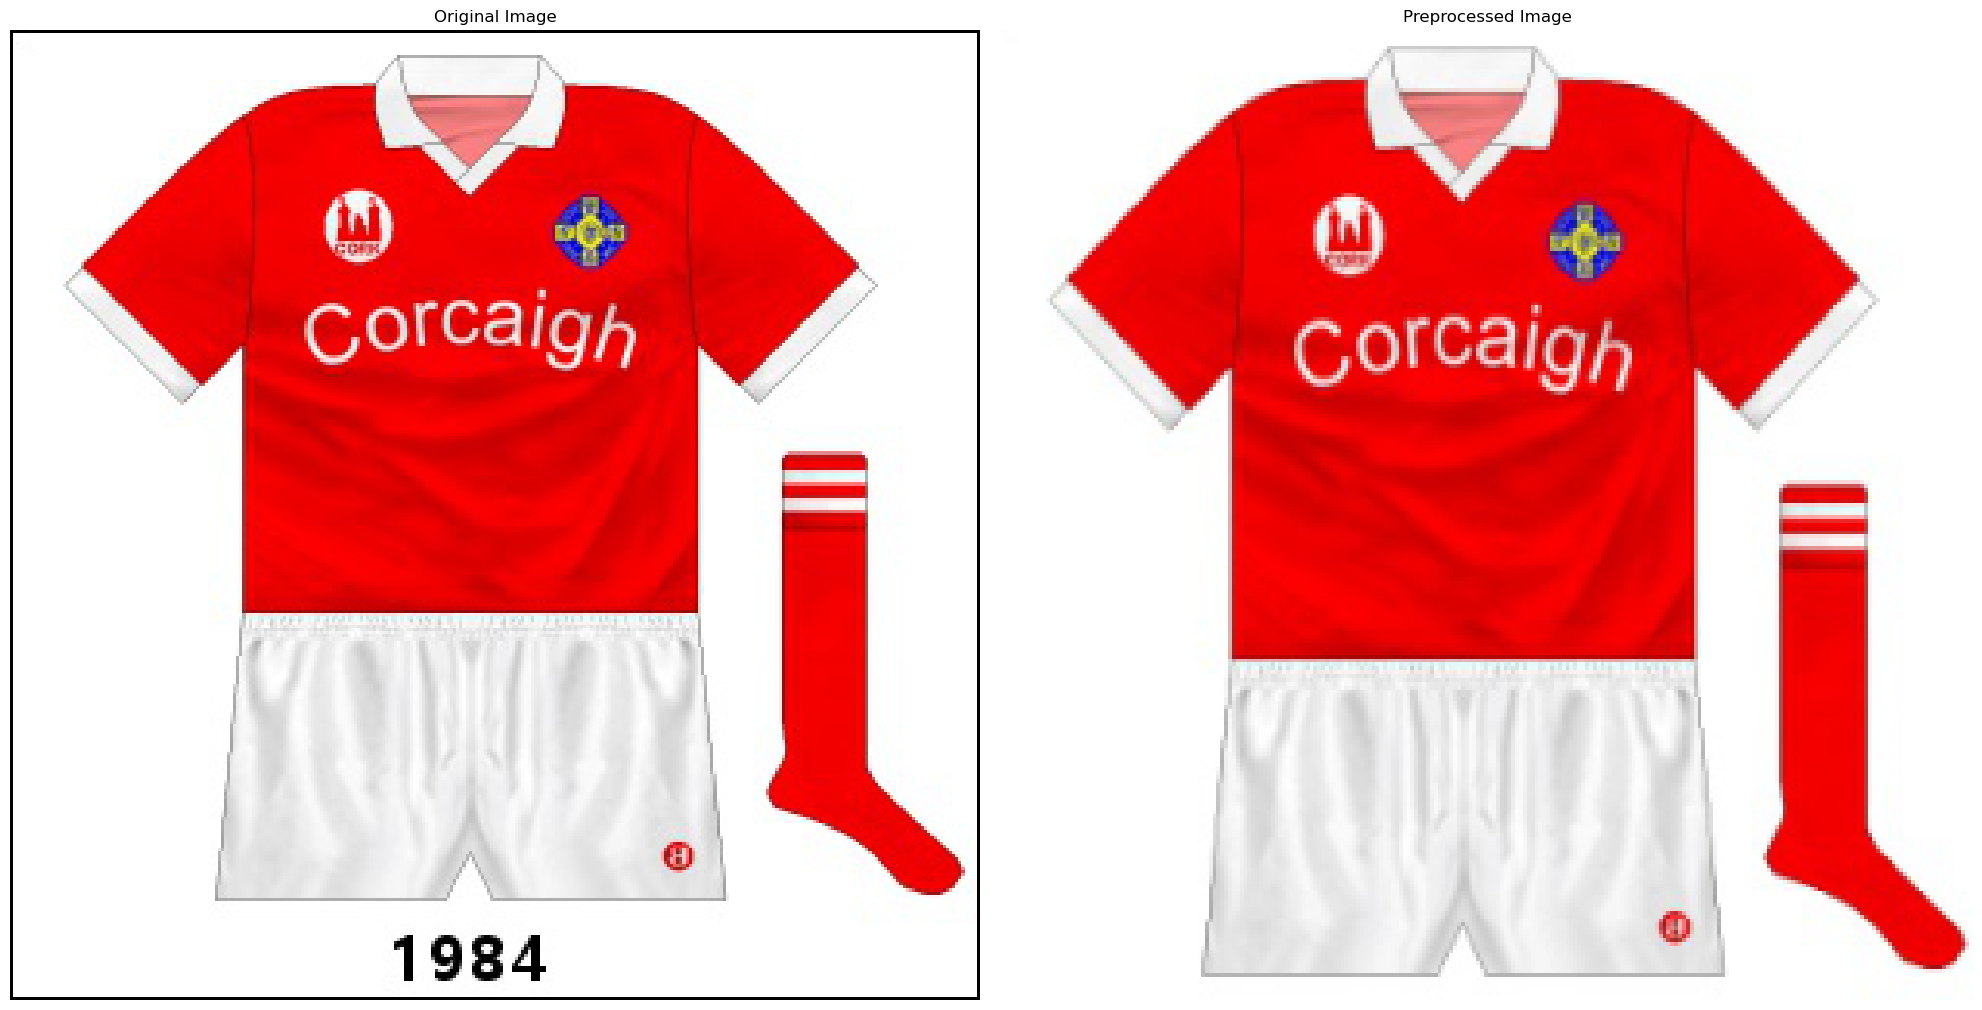

In [147]:
# Load the original image
img = mpimg.imread('Jerseys/cork/cork_0.jpg')

# Display the original image
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Calculate the height of the bottom 8% and top 1% of the image
height, width, _ = img.shape
cut_off_height_bottom = int(height * 0.08)
cut_off_height_top = int(height * 0.01)

# Calculate the width for 1% from sides
cut_off_width_sides = int(width * 0.01)

# Create a modified version of the image with the bottom 8% and top 1% cut off, and 1% from sides
img_cut_off = img[cut_off_height_top:-cut_off_height_bottom, cut_off_width_sides:-cut_off_width_sides, :]

resized_image = cv2.resize(img_cut_off, (250, 250))

# Display the modified image
plt.subplot(1, 2, 2)
plt.imshow(resized_image)
plt.title('Preprocessed Image')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [142]:
def crop_image(image):
    crop_percent_vertical = 9  # For bottom
    crop_percent_horizontal = 1  # For sides
    crop_percent_top = 1  # For top
    
    height, width = image.shape[:2]
    
    # Calculate the new height and width after cropping
    crop_height = int(height * (1 - crop_percent_vertical / 100))
    crop_width = int(width * (1 - 2 * (crop_percent_horizontal / 100)))  # 2 times because left and right
    
    # Calculate how much to crop from the top
    top_crop = int(height * (crop_percent_top / 100))
    
    # Perform the crop
    cropped_image = image[top_crop:crop_height, int(width * crop_percent_horizontal / 100):width - int(width * crop_percent_horizontal / 100), :]
    
    # Resize the cropped image to 250x250
    resized_image = cv2.resize(cropped_image, (250, 250))
    
    return resized_image

In [143]:
# Define the path to your main directory
base_dir = 'Jerseys'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=crop_image,  # Apply custom cropping
    validation_split=0.2,  # Splitting data; 80% for training, 20% for validation
)

# Load images from directories and automatically assign labels based on folder names
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(250, 250),  # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(250, 250),
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 540 images belonging to 33 classes.
Found 121 images belonging to 33 classes.


## Training Images
Let's have a look at some of the training images

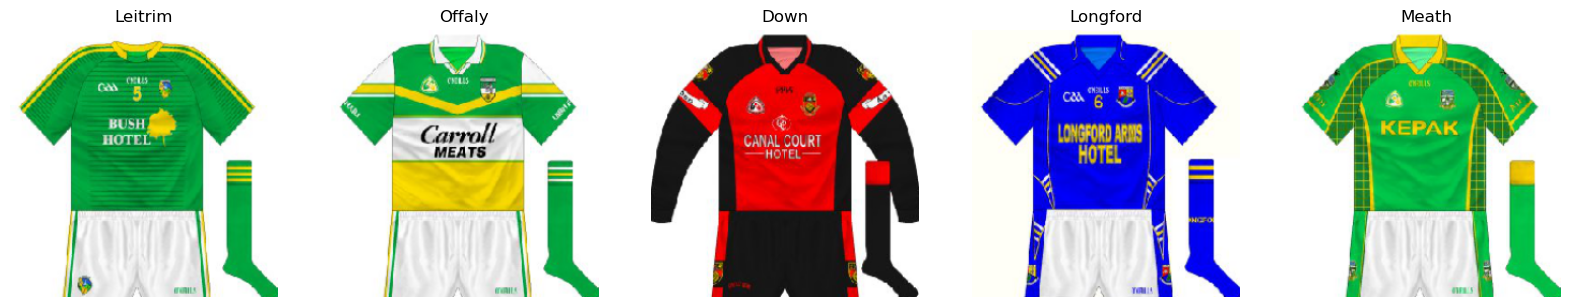

In [144]:
# Assuming 'train_generator' is already defined and loaded with binary class_mode
class_indices = train_generator.class_indices  # This is a dictionary mapping
class_labels = list(class_indices.keys())  # Get class labels as list

# Get a batch of images and labels
images, labels = next(train_generator)

# Adjusted to work with categorical class_mode
def show_images(images, labels):
    _, axs = plt.subplots(1, len(images), figsize=(20, 5))
    if len(images) == 1:
        axs = [axs]
    for img, ax, label_array in zip(images, axs, labels):
        label = class_labels[np.argmax(label_array)]  # Corrected line
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

show_images(images[:5], labels[:5])

# Model

In [149]:
# Simple CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(countyList), activation='softmax')  
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Train the model with the categorical dataset
model.fit(train_generator, validation_data=validation_generator, epochs=6)

# Evaluation

In [132]:
# Predict the classes of the validation set
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = validation_generator.classes

# Calculate the accuracy
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Accuracy: {accuracy:.4f}")

4/4 [==============================] - 0s 92ms/step
Accuracy: 0.9421


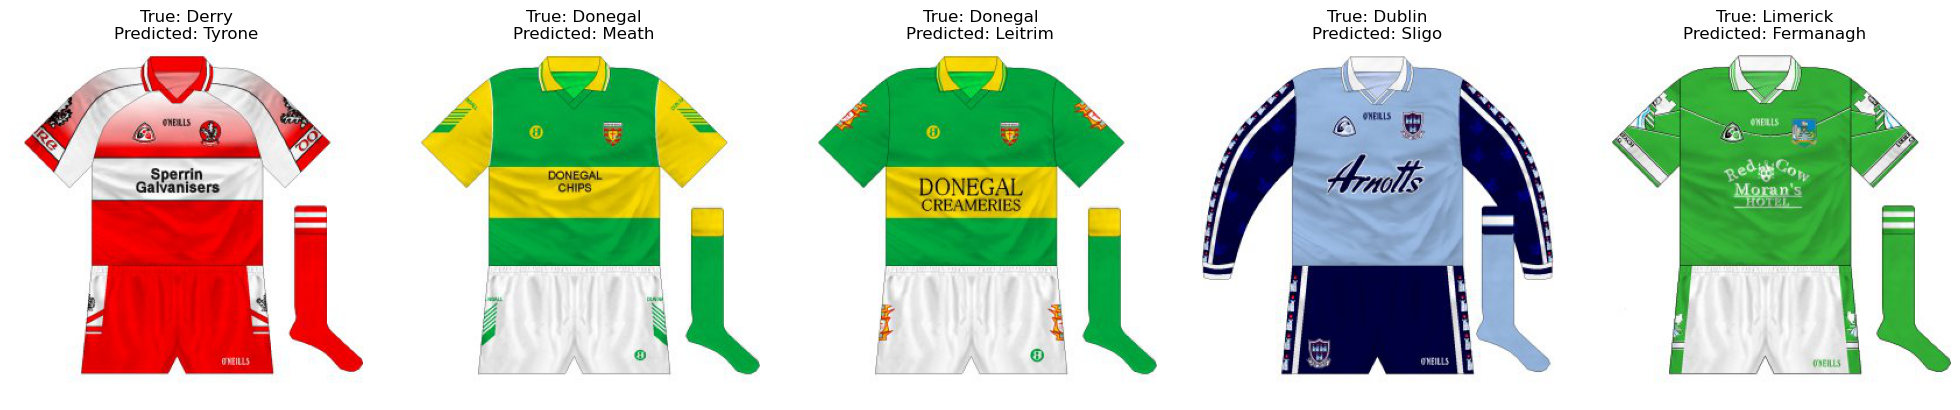

In [133]:
# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

# Find the indices of misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

num_images_to_display = min(5, len(misclassified_indices))
plt.figure(figsize=(num_images_to_display * 4, 4))  # Adjust figure size based on number of images

for i in range(num_images_to_display):
    index = misclassified_indices[i]
    img_path = validation_generator.filepaths[index]  # Get the image file path
    true_label = class_labels[true_classes[index]]
    predicted_label = class_labels[predicted_classes[index]]

    ax = plt.subplot(1, num_images_to_display, i + 1)
    try:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    except Exception as e:
        print(f"Error loading image '{img_path}': {e}")
    
    plt.axis('off')

plt.tight_layout()
plt.show()

In [151]:
# Create a DataFrame with the true and predicted labels
df_misclassified = pd.DataFrame({
    'True Label': [class_labels[label] for label in true_classes[misclassified_indices]],
    'Predicted Label': [class_labels[label] for label in predicted_classes[misclassified_indices]]
})

print("The misclassified kits:")
df_misclassified

The misclassified kits:


,True Label,Predicted Label
0,Derry,Tyrone
1,Donegal,Meath
2,Donegal,Leitrim
3,Dublin,Sligo
4,Limerick,Fermanagh
5,Limerick,Fermanagh
6,Wicklow,Longford
